### Libraries

In [1]:
# ! pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import date
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

## Data preparation

In [3]:
df_train = pd.read_csv('train.csv')
y_train = df_train['label']
X_train = df_train.drop(columns=['label'])

__Let's see if our dataset is balanced__

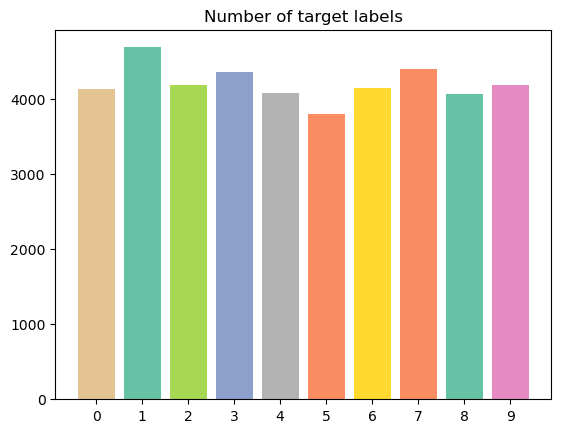

In [4]:
palette = sns.color_palette("Set2", 10)
plt.title("Number of target labels")
plt.bar(x=df_train['label'].value_counts().index, height=df_train['label'].value_counts(), color=palette)
plt.xticks(range(0,10))
plt.show()

In [5]:
X_train.shape

(42000, 784)

__Every image's pixels are stored in row of DataFrame. We want to convert it into square image (28x28) and store in Numpy Arrays__

In [6]:
X_train = X_train.values.reshape(-1, 28, 28)

__Now we can take a look at actual images and their labels__

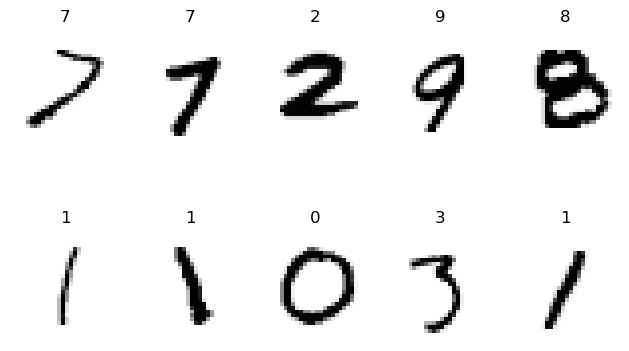

In [7]:
fig, ax = plt.subplots(2,5)

for i, no_sample in enumerate(random.sample(range(0, X_train.shape[0]), 10)):
    row = i // 5
    col = i % 5
    ax[row, col].imshow(X_train[no_sample], cmap=plt.get_cmap('Greys'))
    ax[row, col].axis('off')
    ax[row, col].set_title(y_train[no_sample])
    

plt.tight_layout()
plt.show()

__For modeling, images need to be normalized. In this cas we will use standarization__

In [8]:
X_train = (X_train - X_train.mean()) / X_train.std()

__Same operations need to be performed on test set__

In [9]:
X_test = pd.read_csv('test.csv')

In [10]:
X_test = X_test.values.reshape(-1, 28, 28)

In [11]:
X_test = (X_test - X_test.mean()) / X_test.std()

### Supporting functions

__Function that enables us to chceck model's predictions visually__

In [12]:
def visual_check(X_test, y_pred, least_certain=False):
    
    fig, ax = plt.subplots(5,8)
    
    # this function works in two modes: by default it shows 40 random samples but we can also chceck predictions
    # which model was least certain to
    
    if least_certain:
        indexes = pd.DataFrame(y_pred).max(axis=1).sort_values()[:40].index
    else:
        indexes = random.sample(range(0, X_test.shape[0]), 40)

    for i, no_sample in enumerate(indexes):
        row = i // 8
        col = i % 8
        ax[row, col].imshow(X_test[no_sample], cmap=plt.get_cmap('Greys'))
        ax[row, col].axis('off')
        prediction = np.argmax(y_pred[no_sample])
        proba = y_pred[no_sample].max()
        ax[row, col].set_title(f'{prediction} ({proba:.2f})', fontsize=8)
        
    plt.suptitle("Model's predictions with probability (in brackets)")

    plt.tight_layout()
    plt.show()

__Function saving results, models and their history into pickles__

In [13]:
def saving(name, model, history, test_score):
    
    try:
        results = pickle.load(open('results', 'rb'))
     
    # this exception works only when we save first model and results file hasn't been created yet
    except FileNotFoundError:
        results = pd.DataFrame({
            'name' : [],
            'val_acc' : [],
            'test_acc' : []
        })
    
    new_model = pd.DataFrame({
    'name' : [name],
    'val_acc' : [np.max(history.history['val_accuracy'])],
    'test_acc' : [test_score]
    })
    
    results = pd.concat([results, new_model], axis=0)
    
    with open('results', 'wb') as file:
        pickle.dump(results.reset_index(drop=True), file)
    with open(f'models/{name}', 'wb') as file:
        pickle.dump(model, file)
    with open(f'models/{name}_history', 'wb') as file:
        pickle.dump(history, file)

__Function preparing submission file for Kaggle__

In [14]:
def submission_file(y_pred, name):
    
    results = pd.DataFrame({
        'ImageID' : pd.Series(range(1,28001)),
        'Label' : pd.Series(np.argmax(y_pred, axis=1))
    })
    
    file_name = 'submissions/' + str(date.today()) + '_' + name + '.csv'
    
    results.to_csv(file_name, index=False)

## Modeling

__Modeling stage will be divided on two stages. First, we will build Fully Connected Neural Network and in the second stage Convolutional Neural Network. Starting with very simple models, we will deepen our networks and experiment with adding different parameters.__

__Parameters common for all models will be:__

__- Output layer: 10 outputs with softmax activation__

__- Optimizer: Adam__

__- Loss Function: 'sparse_categorical_crossentropy'__

__- Metric: accuracy__

### Fully Connected Neural Networks

#### Linear Model

In [15]:
model1 = Sequential([
    
    # we need to flatten our data into vector everytime before first Dense layer 
    Flatten(input_shape=(28,28)),
    Dense(10, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# history1 = model1.fit(X_train, y_train, epochs=50, validation_split=0.2)
# y_pred = model1.predict(X_test)
# submission_file(y_pred, 'linear_model')

In [17]:
# saving("Linear Model", model1, history1, 0.91282)

__Linear model with no hidden layers achieved solid accuracy above 91%__

#### One-layer Fully Conected Neural Network model

In [18]:
model2 = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# history2 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2)
# y_pred = model2.predict(X_test)
# submission_file(y_pred, 'one_layer_fc_nn1')

In [20]:
# saving("One layer FC NN", model2, history2, 0.97203)

__Adding first hidden layer caused significant improvement in accuracy__

#### Two-layers Fully Conected Neural Network model

In [21]:
model3 = Sequential([
    Flatten(input_shape=(28,28), name='Flattening'),
    Dense(256, activation='relu', name='First_layer'),
    Dense(128, activation='relu', name='Second_layer'),
    Dense(10, activation='softmax', name='Output_layer')
])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 First_layer (Dense)         (None, 256)               200960    
                                                                 
 Second_layer (Dense)        (None, 128)               32896     
                                                                 
 Output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# history3 = model3.fit(X_train, y_train, epochs=50, validation_split=0.2)
# y_pred = model3.predict(X_test)
# submission_file(y_pred, 'two_layers_fc_nn2')

In [23]:
# saving("Two layers FC NN", model3, history3, 0.97492)

__The result is slightly better than in one layer network__

#### Three-layers Fully Conected Neural Network model

In [24]:
model4 = Sequential([
    Flatten(input_shape=(28,28), name='Flattening'),
    Dense(512, activation='relu', name='First_layer'),
    Dense(256, activation='relu', name='Second_layer'),
    Dense(128, activation='relu', name='Third_layer'),
    Dense(10, activation='softmax', name='Output_layer')
])

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 First_layer (Dense)         (None, 512)               401920    
                                                                 
 Second_layer (Dense)        (None, 256)               131328    
                                                                 
 Third_layer (Dense)         (None, 128)               32896     
                                                                 
 Output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 567434 (2.16 MB)
Trainable params: 567434 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# history4 = model4.fit(X_train, y_train, epochs=50, validation_split=0.2)
# y_pred = model4.predict(X_test)
# submission_file(y_pred, 'three_layers_fc_nn1')

In [26]:
# saving("Three layers FC NN", model4, history4, 0.97800)

__There's further improvement so we will add next layer__

#### Four-layers Fully Conected Neural Network model

In [27]:
model5 = Sequential([
    Flatten(input_shape=(28,28), name='Flattening'),
    Dense(512, activation='relu', name='First_layer'),
    Dense(256, activation='relu', name='Second_layer'),
    Dense(256, activation='relu', name='Third_layer'),
    Dense(128, activation='relu', name='Fourth_layer'),
    Dense(10, activation='softmax', name='Output_layer')
])

model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 First_layer (Dense)         (None, 512)               401920    
                                                                 
 Second_layer (Dense)        (None, 256)               131328    
                                                                 
 Third_layer (Dense)         (None, 256)               65792     
                                                                 
 Fourth_layer (Dense)        (None, 128)               32896     
                                                                 
 Output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 633226 (2.42 MB)
Trainable params: 63322

In [28]:
# history5 = model5.fit(X_train, y_train, epochs=50, validation_split=0.2)
# y_pred = model5.predict(X_test)
# submission_file(y_pred, 'four_layers_fc_nn1')

In [29]:
# saving("Four layers FC NN", model5, history5, 0.97396)

__There's decrease in accuracy. We have to remember that neural networks' results are random to some extent so it doesn't necessarily imply that adding additional layers won't improve our model. Nevertheless, we will stop at that point and focus on other parameters.__

#### 4L FC NN with increased batch size

__As our model converges quite fast, we can experiment with batch size. So far, we used default value which is 32 in that case. Now, it will be increased significantly to 512 to see if it affects the result__

In [30]:
model6 = Sequential([
    Flatten(input_shape=(28,28), name='Flattening'),
    Dense(512, activation='relu', name='First_layer'),
    Dense(256, activation='relu', name='Second_layer'),
    Dense(256, activation='relu', name='Third_layer'),
    Dense(128, activation='relu', name='Fourth_layer'),
    Dense(10, activation='softmax', name='Output_layer')
])

model6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 First_layer (Dense)         (None, 512)               401920    
                                                                 
 Second_layer (Dense)        (None, 256)               131328    
                                                                 
 Third_layer (Dense)         (None, 256)               65792     
                                                                 
 Fourth_layer (Dense)        (None, 128)               32896     
                                                                 
 Output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 633226 (2.42 MB)
Trainable params: 63322

In [31]:
# history6 = model6.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=512)
# y_pred = model6.predict(X_test)
# submission_file(y_pred, 'four_layers_fc_nn2')

In [32]:
# saving("4L FC NN + batch = 512", model6, history6, 0.98032)

__Model in this configuration manages to achive best result so far. Therefore, we will leave batch size value at 512__

#### adding early stopping

__So far, our models run for 50 epochs each which was probably appropriate value as they didn't seem to overfit nor does a larger number of epochs seem to have a positive impact on their performance. However, as our models grow it may be the case. That's why we will use early stopping, which causes that model would stop after given number of epochs without improvement__

In [33]:
model7 = Sequential([
    Flatten(input_shape=(28,28), name='Flattening'),
    Dense(512, activation='relu', name='First_layer'),
    Dense(256, activation='relu', name='Second_layer'),
    Dense(256, activation='relu', name='Third_layer'),
    Dense(128, activation='relu', name='Fourth_layer'),
    Dense(10, activation='softmax', name='Output_layer')
])

model7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 First_layer (Dense)         (None, 512)               401920    
                                                                 
 Second_layer (Dense)        (None, 256)               131328    
                                                                 
 Third_layer (Dense)         (None, 256)               65792     
                                                                 
 Fourth_layer (Dense)        (None, 128)               32896     
                                                                 
 Output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 633226 (2.42 MB)
Trainable params: 63322

__EarlyStopping is one of the 'callbacks' parameters. We set it that it waits for 20 epochs to improve for at least 0.001 (loss function decrease). If it doesn't happen it came back to weights when the model achieved best results__

In [34]:
early_stopping = EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)

In [35]:
# history7 = model7.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=512, callbacks=[early_stopping])
# y_pred = model7.predict(X_test)
# submission_file(y_pred, 'four_layers_fc_nn3')

In [36]:
# saving("4L FC NN + early stopping", model7, history7, 0.98000)

__Validation accuracy and test accuracy are almost the same as before but it was achieved in 25 epochs instead of 50__

#### Adding dropout

__We will add dropout after every hidden layer which means that some percentage of neurons are switched of in every iteration. It may cause network to generalize better__

In [37]:
model8 = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [38]:
# history8 = model8.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=512, callbacks=[early_stopping])
# y_pred = model8.predict(X_test)
# submission_file(y_pred, 'four_layers_fc_nn4')

In [39]:
# saving("4L FC NN + dropout", model8, history8, 0.97571)

__There's slight decrease in test accuracy (and increase in validation accuracy). It's tough to evaluate if dropout helps or disturb our model. We will experiment further with this parameter__ 

#### Adding batch normalization

In [40]:
model9 = Sequential([
    Flatten(input_shape=(28,28)),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model9.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_8 (Dense)             (None, 512)               401920    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)              

In [41]:
# history9 = model9.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=512, callbacks=[early_stopping])
# y_pred = model9.predict(X_test)
# submission_file(y_pred, 'four_layers_fc_nn5')

In [42]:
# saving("4L FC NN + batch norm", model9, history9, 0.97246)

__There's decrese in accuracies. Of course, it cannot be said with certainty that Batch Normalization worsen our model but we won't use it in next models__

#### Data Augmentation

__This is technique that modifies our data in given range which causes that model is trained with broader range of data__

In [43]:
model10 = Sequential([
    Flatten(input_shape=(28,28), name='Flattening'),
    Dense(512, activation='relu', name='First_layer'),
    Dense(256, activation='relu', name='Second_layer'),
    Dense(256, activation='relu', name='Third_layer'),
    Dense(128, activation='relu', name='Fourth_layer'),
    Dense(10, activation='softmax', name='Output_layer')
])

model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model10.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 First_layer (Dense)         (None, 512)               401920    
                                                                 
 Second_layer (Dense)        (None, 256)               131328    
                                                                 
 Third_layer (Dense)         (None, 256)               65792     
                                                                 
 Fourth_layer (Dense)        (None, 128)               32896     
                                                                 
 Output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 633226 (2.42 MB)
Trainable params: 63322

__We can use tensorflow's ImageDataGenerator to obtain augmented data. It forces us to change a little bit use of fit method. For example validation split cannot be used. We need to create training and calidation data on our own. We also need to expand our data with additional dimension as ImageDataGenerator is adapted to color images with additional RGB channel, which is absent in MNIST dataset__ 

In [44]:
image_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    validation_split=0.2
)

In [45]:
X_train_gen = np.expand_dims(X_train, axis=-1)
train_gen = image_gen.flow(X_train_gen, y_train, batch_size=512, subset='training')
val_gen = image_gen.flow(X_train_gen, y_train, batch_size=512, subset='validation')

In [46]:
# history10 = model10.fit(
#     image_gen.flow(X_train_gen, y_train, batch_size=512),
#     steps_per_epoch=0.8*len(X_train_gen)/512,
#     epochs=200,
#     validation_data=val_gen,
#     validation_steps=0.2*len(X_train_gen)/512,
#     callbacks=[early_stopping]
# )

# y_pred = model10.predict(X_test)
# submission_file(y_pred, 'four_layers_fc_nn6')

In [47]:
# saving("4L FC NN + data aug (no dropout and batch norm)", model10, history10, 0.9866)

__There is massive improvement so we will perform next experiments with augmented data__

#### 5 layers with dropout

__Now we will deepen our network with one layer again and experiment further with Dropout__

In [48]:
model11 = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model11.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model11.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 1024)              803840    
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)             

In [49]:
# history11 = model11.fit(
#     image_gen.flow(X_train_gen, y_train, batch_size=512),
#     steps_per_epoch=0.8*len(X_train_gen)/512,
#     epochs=200,
#     validation_data=val_gen,
#     validation_steps=0.2*len(X_train_gen)/512,
#     callbacks=[early_stopping]
# )

# y_pred = model11.predict(X_test)
# submission_file(y_pred, 'five_layers_fc_nn')

In [50]:
# saving("5L FC NN + data aug + dropout", model11, history11, 0.99089)

__Best result so far!__

#### 5L no droupout

In [51]:
model12 = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model12.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model12.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 1024)              803840    
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 10)              

In [52]:
# history12 = model12.fit(
#     image_gen.flow(X_train_gen, y_train, batch_size=512),
#     steps_per_epoch=0.8*len(X_train_gen)/512,
#     epochs=200,
#     validation_data=val_gen,
#     validation_steps=0.2*len(X_train_gen)/512,
#     callbacks=[early_stopping]
# )

# y_pred = model12.predict(X_test)
# submission_file(y_pred, 'five_layers_fc_nn2')

In [53]:
# saving("5L FC NN + data aug", model12, history12, 0.99103)

__Even better but very similar result. We can cautiously assume that Dropout doesn't play great role in our model. Let's chceck if futher deepening will still cause improvement__

#### 6L FC NN

In [54]:
model13 = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model13.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model13.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_25 (Dense)            (None, 1024)              803840    
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (None, 256)               65792     
                                                                 
 dense_30 (Dense)            (None, 128)             

In [55]:
# history13 = model13.fit(
#     image_gen.flow(X_train_gen, y_train, batch_size=512),
#     steps_per_epoch=0.8*len(X_train_gen)/512,
#     epochs=300,
#     validation_data=val_gen,
#     validation_steps=0.2*len(X_train_gen)/512,
#     callbacks=[early_stopping]
# )

# y_pred = model13.predict(X_test)
# submission_file(y_pred, 'six_layers_fc_nn')

In [56]:
# saving("6L FC NN + data aug", model13, history13, 0.98946)

__The addition on 6th layer doesn't seem to improve our model. We will finish experiments with FC NN at this point__

#### FC NN - Summary

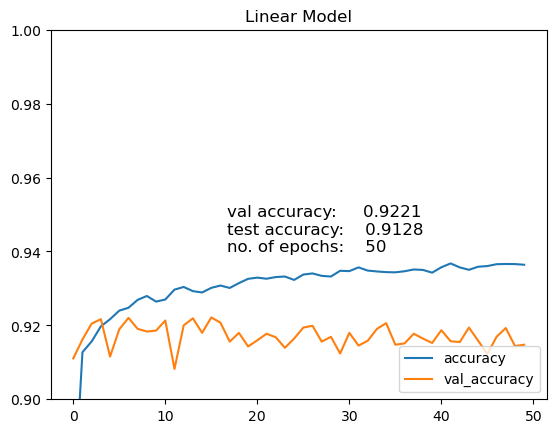

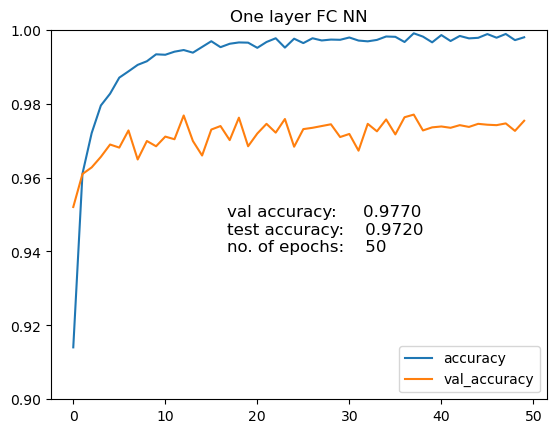

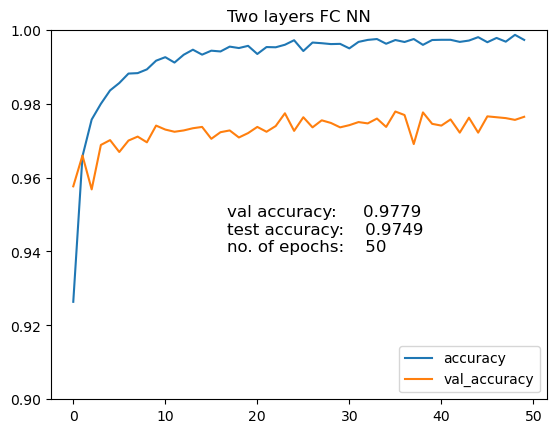

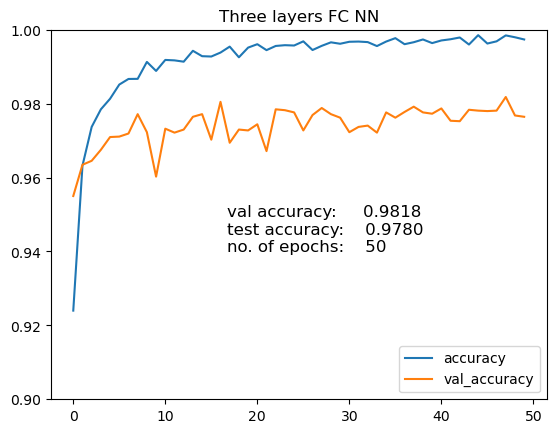

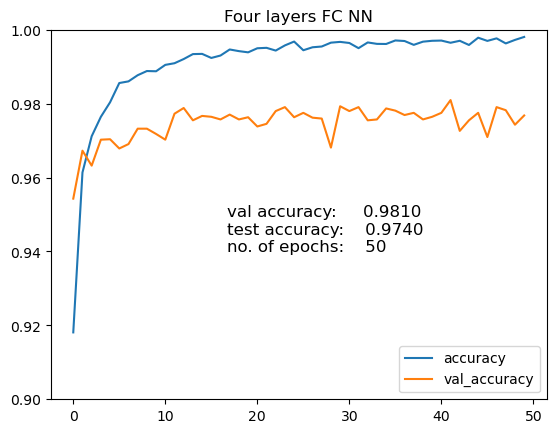

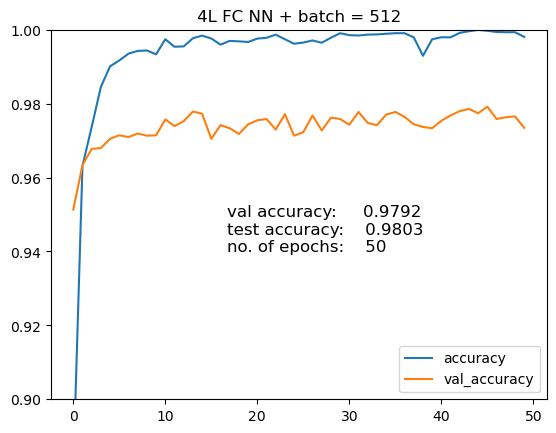

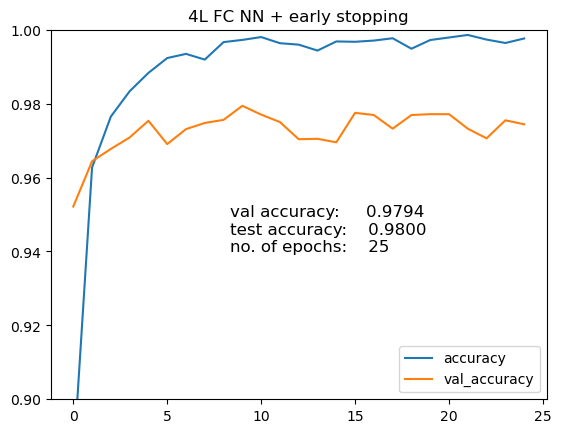

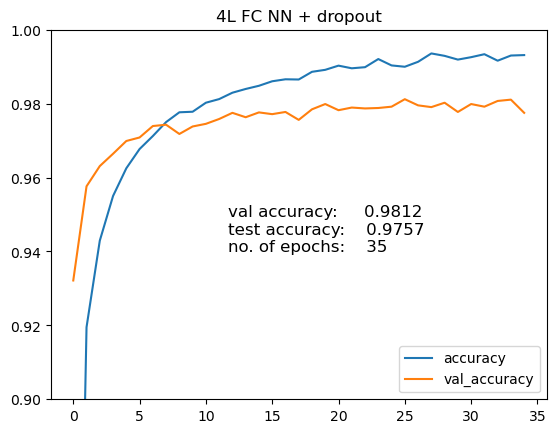

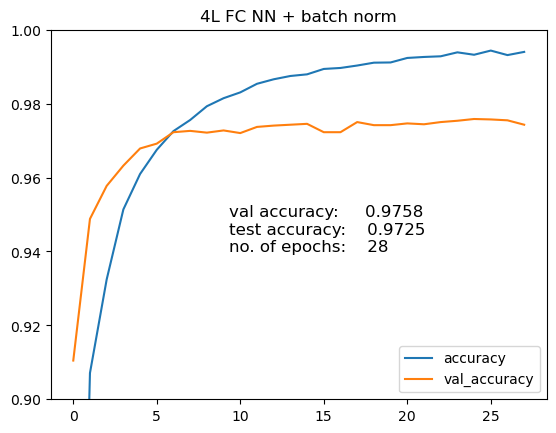

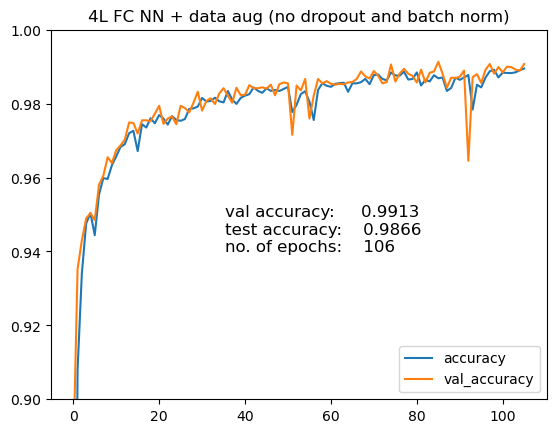

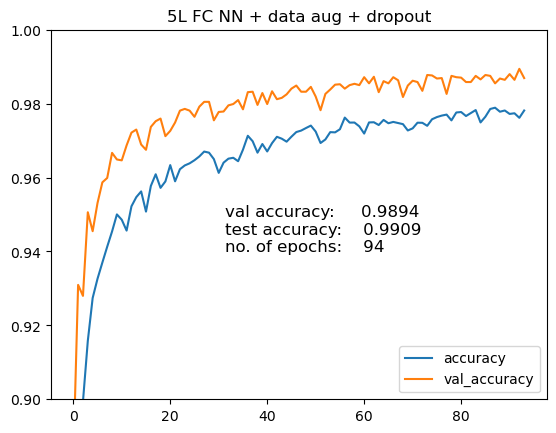

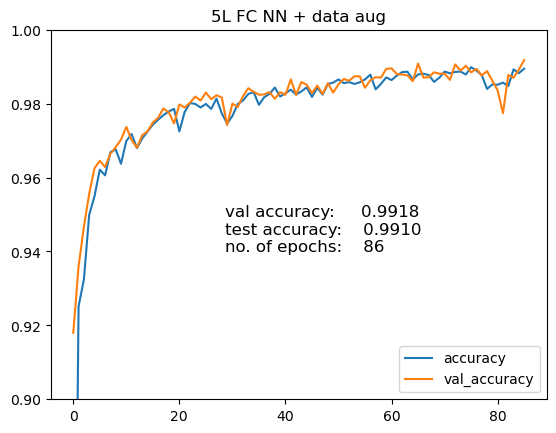

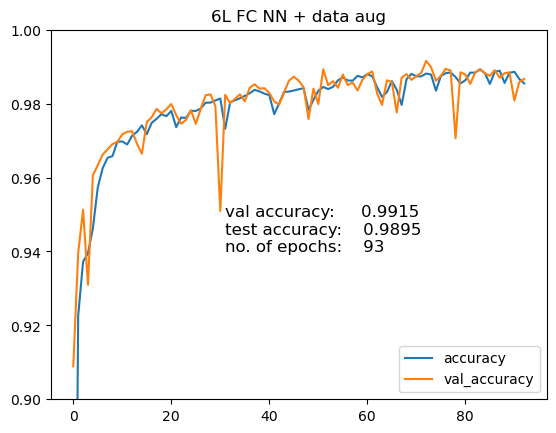

In [57]:
results = pickle.load(open('results', 'rb'))
models = results['name'].to_list()[:13]

for model in models:
    
    history_filename = 'models/' + model + '_history'
    history = pickle.load(open(history_filename, 'rb'))
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    no_epochs = len(val_accuracy)
    best_val_acc = results[results['name']==model]['val_acc'].iloc[0]
    test_acc = results[results['name']==model]['test_acc'].iloc[0]
    
    plt.title(model)
    plt.plot(range(no_epochs), accuracy, label='accuracy')
    plt.plot(range(no_epochs), val_accuracy, label ='val_accuracy')
    plt.legend(loc='lower right')
    plt.ylim(0.9,1)
    plt.text(no_epochs/3, 0.94,
             s=f'val accuracy:     {best_val_acc:.4f}\n'
               f'test accuracy:    {test_acc:.4f}\n'
               f'no. of epochs:    {no_epochs}',
             fontsize=12)

    plt.show()

__In general, deepening NN gives good results to some point - in our case it was five hidden layers. Also increasing batch size seemed to help. Batch Normalization and Dropout rather didn't affected model in positive way - maybe because our problem is quite simple. Addition of data augmentation influenced model significantly.__

__Our best Fully Connected Neural Networks managed to achieve accuracy larger than 99% which seems to be very good result as Convolutional Neural Networks seem to be more appropriate choice for image recognition tasks. Despite that, scores of 99% places them in top 20% on Kaggle's Leaderboard. Let's see if we can beat this result using CNN.__

### Convolutional Neural Network

#### One Layer Convolutional Neural Network

__We will start with simple one layer CNN followed by Max Pooling and after flattening, one layer FC NN. During this project we will use parameters like kernel size, padding and stride unchanged for all models due to limited scope of the project. However they can also be adjusted__

__All convolutional models will be fitted using early stopping mechanism because it worked well earlier__

In [58]:
cnn_model1 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1), padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model1.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 flatten_7 (Flatten)         (None, 6272)              0         
                                                                 
 dense_32 (Dense)            (None, 128)               802944    
                                                                 
 dense_33 (Dense)            (None, 10)                1290      
                                                                 
Total params: 804554 (3.07 MB)
Trainable params: 804554 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [59]:
# cnn_history1 = cnn_model1.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model1.predict(X_test)
# submission_file(y_pred, 'one_layer_cnn2')

In [60]:
# saving("1L CNN", cnn_model1, cnn_history1, 0.98046)

__Our simpliest CNN achieved above 98% which is better than simple FC NNs__

#### 2L CNN

In [61]:
cnn_model2 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1), padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 3136)              0         
                                                                 
 dense_34 (Dense)            (None, 128)             

In [62]:
# cnn_history2 = cnn_model2.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model2.predict(X_test)
# submission_file(y_pred, '2L_cnn1')

In [63]:
# saving("2L CNN", cnn_model2, cnn_history2, 0.98792)

__Adding second layer caused visible improvement__

__3L CNN__

In [64]:
cnn_model3 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1), padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 128)       

In [65]:
# cnn_history3 = cnn_model3.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model3.predict(X_test)
# submission_file(y_pred, '3L_cnn1')

In [66]:
# saving("3L CNN", cnn_model3, cnn_history3, 0.9866)

__There's no improvement. What's more, our input images are quite small (28x28) and every MaxPool layer reduces it twice so we can't use more of them. As we want to deepen our network we need to change it architecture a little bit__

#### 4L CNN

__We will add two Conv layers followed by MaxPool, repeated twice__

In [67]:
cnn_model4 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model4.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                

In [68]:
# cnn_history4 = cnn_model4.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model4.predict(X_test)
# submission_file(y_pred, '4L_cnn1')

In [69]:
# saving("4L CNN", cnn_model4, cnn_history4, 0.98957)

__Model seems to improve and almost reached 99%. It's time to use Data Augmentation before we keep to deepen the network__

#### 4L CNN + data augmentation

__This time we will use another way to add augmented data than in first stage of the project. In tensorflow.keras.layers.experimental.preprocessing there are implemented operations that can be added directly to the model, like layers. Then we can use fit method in it's simplier form__

In [70]:
cnn_model5 = Sequential([
    InputLayer(input_shape=(28,28,1)),
    
    preprocessing.RandomRotation(factor=0.1),
    preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model5.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 28, 28, 1)         0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 random_translation (Random  (None, 28, 28, 1)         0         
 Translation)                                                    
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)      

In [71]:
# cnn_history5 = cnn_model5.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model5.predict(X_test)
# submission_file(y_pred, '4L_cnn1 + data aug')

In [72]:
# saving("4L CNN + data aug", cnn_model5, cnn_history5, 0.99192)

__As in the first stage, Data Augmentation gave us significant improvement and best result so far__

#### Adding Batch Normalization and Dropout

In [73]:
cnn_model6 = Sequential([
    InputLayer(input_shape=(28,28,1)),
    
    preprocessing.RandomRotation(factor=0.1),
    preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model6.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 random_translation_1 (Rand  (None, 28, 28, 1)         0         
 omTranslation)                                                  
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                     

In [74]:
# cnn_history6 = cnn_model6.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model6.predict(X_test)
# submission_file(y_pred, '4L_cnn1 + batch + dropout')

In [75]:
# saving("4L CNN + batch + dropout", cnn_model6, cnn_history6, 0.99085)

__The accuracy deacreased slightly but we will still experiment with these parameters. By now, let's deepen the network even more__

__6L CNN__

In [76]:
cnn_model7 = Sequential([
    InputLayer(input_shape=(28,28,1)),
    
    preprocessing.RandomRotation(factor=0.1),
    preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),

    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model7.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 random_zoom_2 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 random_translation_2 (Rand  (None, 28, 28, 1)         0         
 omTranslation)                                                  
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 32)      

In [77]:
# cnn_history7 = cnn_model7.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model7.predict(X_test)
# submission_file(y_pred, '6L_cnn')

In [78]:
# saving("6L CNN", cnn_model7, cnn_history7, 0.98967)

__The metric kept decreasing__

#### Adding second FC layer

__Let's keep the previous model and see what happens if we add second FC layer__

In [79]:
cnn_model8 = Sequential([
    InputLayer(input_shape=(28,28,1)),
    
    preprocessing.RandomRotation(factor=0.1),
    preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model8.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_3 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 random_zoom_3 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 random_translation_3 (Rand  (None, 28, 28, 1)         0         
 omTranslation)                                                  
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 32)      

In [80]:
# cnn_history8 = cnn_model8.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model8.predict(X_test)
# submission_file(y_pred, '6L_cnn + 2FC')

In [81]:
# saving("6L CNN + 2FC", cnn_model8, cnn_history8, 0.98828)

__It doesn't seem to improve the model. We will stay with one FC layer but increase number of neurons__

#### 6L CNN with Batch Normalization and 40% Dropout

In [82]:
cnn_model9 = Sequential([
    InputLayer(input_shape=(28,28,1)),
    
    preprocessing.RandomRotation(factor=0.1),
    preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.4),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.4),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model9.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_4 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 random_zoom_4 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 random_translation_4 (Rand  (None, 28, 28, 1)         0         
 omTranslation)                                                  
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_7 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                     

In [83]:
# cnn_history9 = cnn_model9.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# y_pred = cnn_model9.predict(X_test)
# submission_file(y_pred, '6L_cnn2')

In [84]:
# saving("6L CNN2", cnn_model9, cnn_history9, 0.99371)

__Our best score!__

#### CNN - Summary

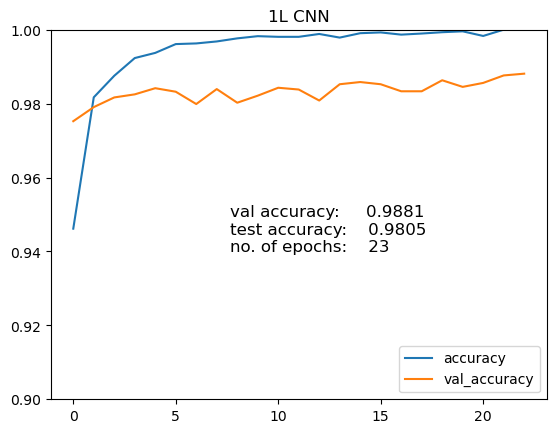

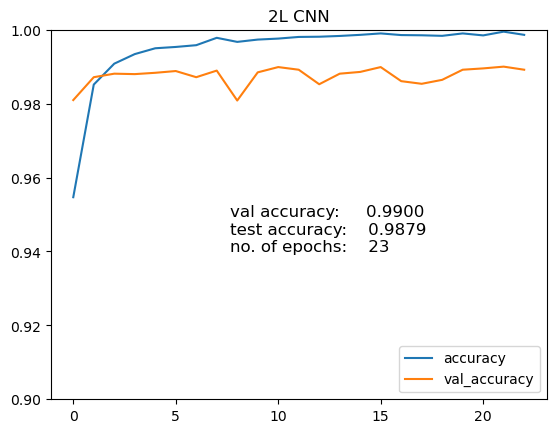

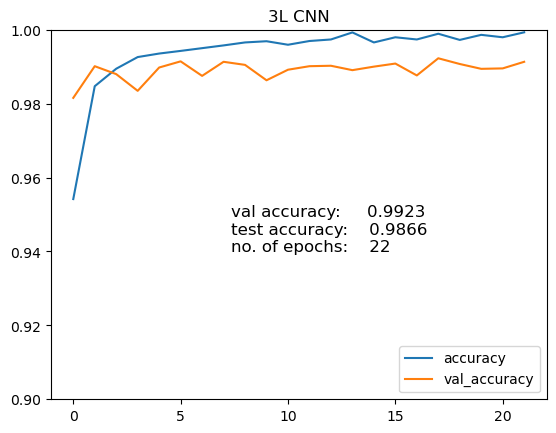

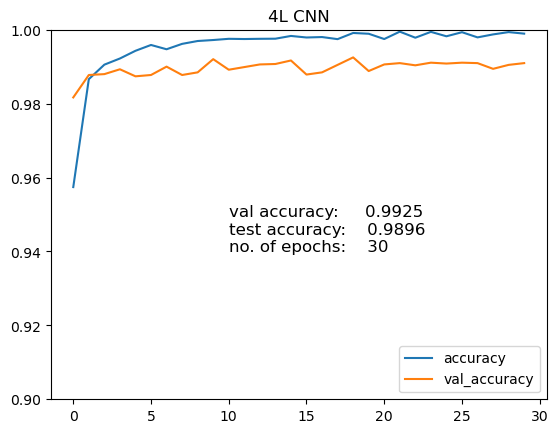

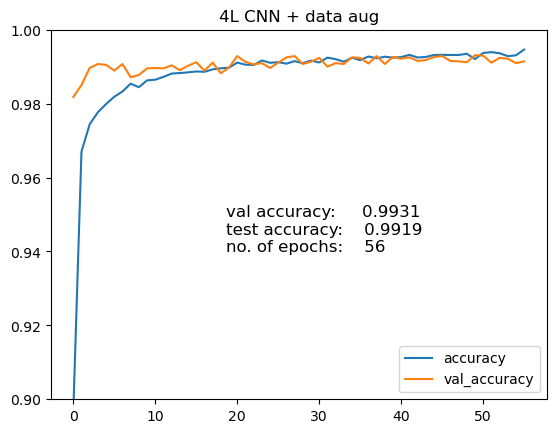

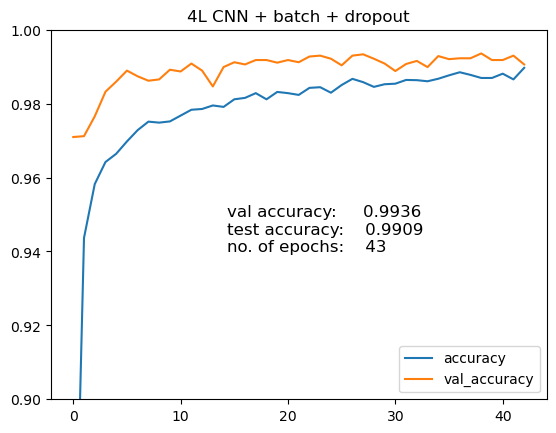

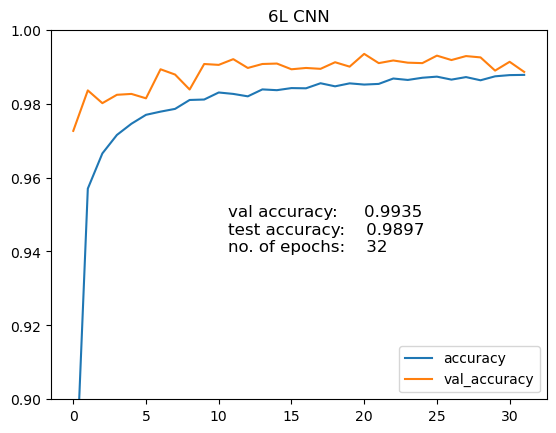

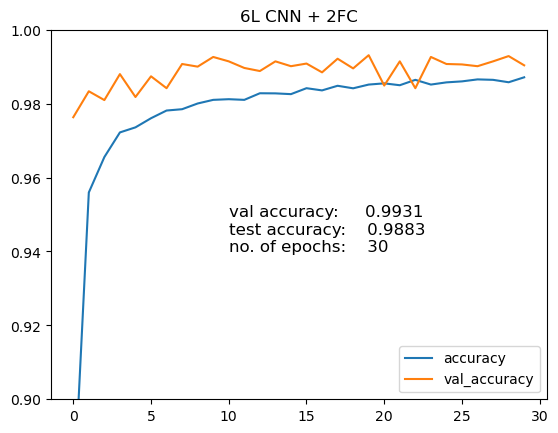

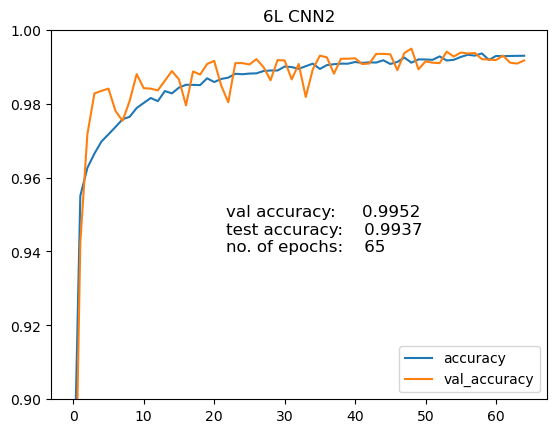

In [85]:
results = pickle.load(open('results', 'rb'))
models = results['name'].to_list()[13:-1]

for model in models:
    
    history_filename = 'models/' + model + '_history'
    history = pickle.load(open(history_filename, 'rb'))
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    no_epochs = len(val_accuracy)
    best_val_acc = results[results['name']==model]['val_acc'].iloc[0]
    test_acc = results[results['name']==model]['test_acc'].iloc[0]
    
    plt.title(model)
    plt.plot(range(no_epochs), accuracy, label='accuracy')
    plt.plot(range(no_epochs), val_accuracy, label ='val_accuracy')
    plt.legend(loc='lower right')
    plt.ylim(0.9,1)
    plt.text(no_epochs/3, 0.94,
             s=f'val accuracy:     {best_val_acc:.4f}\n'
               f'test accuracy:    {test_acc:.4f}\n'
               f'no. of epochs:    {no_epochs}',
             fontsize=12)

    plt.show()

__Similary to FC NN, deepening our networks gave good results as well as adding data augmentation. In the last experiment addition of Batch Normalization after every layer and Dropouts after every segment seemed to affect network positively as we achived best result__

__The final result of 99.37% seems to be objectively good beacuse it placed in top 10% on Kaggle's Leaderboard__